# Week 12: Unsupervised Learning (K-means Clustering)

```
- Machine Learning, Innopolis University (Fall semester 2023)
- Professor: Adil Khan
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
In this lab, you will practice Clustering techniques

Lab Plan
1. K-means
2. K-means++
3. Choosing optimal k
```

<hr>


## 1. K-means

![](https://miro.medium.com/max/1200/1*rw8IUza1dbffBhiA4i0GNQ.png)

K-means is an unsupervised ML technique to cluster unlabeled dataset to k clusters where each datapoint belongs to a cluster with the nearest centroid.

##### Thoughts:
What's the pros and cons of K-means?

<span style="color:blue">
Pros:

1. Scales good with large datasets
2. Guarantees convergence.
3. generalize well with clusters of globular, spherical,or elliptical shapes.

Cons:
1. K has to be chosen manually. (we can use the loss vs the #cluster method)
2. Being dependent on the initial state
3. Not efficient at clustering data with varying densities and sizes.
4. It doesn't scale good when the number of dimensions gets so big as the distance metric will converge to a constant value between any given examples.
(so we may need to reduce dimensions first)

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1.1 Data generation

In [ ]:
from sklearn.datasets import make_blobs
import pandas as pd
import plotly.express as px

real_centers = [[1,1], [5,5], [8, 1]]
X, y = make_blobs(n_samples=300, centers=real_centers, n_features=2,
                   random_state=0,)

df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['label'] = y

fig = px.scatter(df, x='Feature 1', y='Feature 2', title='My Unlabeled Data', marginal_x="histogram", marginal_y="histogram")
fig.show()

## 1.2 Implementing K-means method

### <span style="color:red">Task: implement the fit and predict function of K-means class here.

K-means steps
data is given
1. initialize the centroids randomly
2. calculate distance from all centers to each point
3. assign the point to the cluster where the distance is the minimum
3. for each point assign label based on closest center
4. recompute the centers -> 2.step

5. check the distance(difference) between current centers and the previous centers(componentwise), and new centers.
6. if difference is <= (epsilon): we stop
   else: we go to step 2.


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.spatial.distance import cdist
from copy import deepcopy

class KMeans(BaseEstimator, ClassifierMixin):

    def __init__(self, k=3, centers=None):
        self.k = k
        self.centers = centers

    def _predict(self, X, centers):
        # (1 line) Calculate the pairwise distance
        # between each sample in X and the centroids.
        distances = cdist(X, centers)
        return np.argmin(distances, axis=1)

    def predict(self, X, y=None):
        return self._predict(X, self.centers)

    def fit(self, X, y=None):
        c = X.shape[1]
        if self.centers is None:
            mean = np.mean(X, axis = 0)
            std = np.std(X, axis = 0)
            self.centers = np.random.randn(self.k, c) * std + mean
        centers = self.centers
        centers_new = deepcopy(self.centers) # Store new centers

        error = -1

        # When, after an update, the estimate of that center stays the same, exit loop
        while error != 0:
            # Predict clusters of each point using the current clusters
            clusters = self._predict(X, centers)
            centers_old = deepcopy(centers_new)
            # Calculate mean for every cluster and update the center in 'centers_new'
            for i in range(self.k):
                computed_centers = np.array(X[clusters == j].mean(axis=0) for j in range(self.k))
                centers = np.mean(X[clusters])
                if np.all(self.centers == computed_centers):
                    break
                self.centers = computed_centers
                # pass # TODO

            error = np.linalg.norm(centers_new - centers_old)
            centers = centers_new
        self.centers = centers_new
        return self

    def score(self, X, y=None):
        return 0


Train and predict K-means model on the generated dataset.

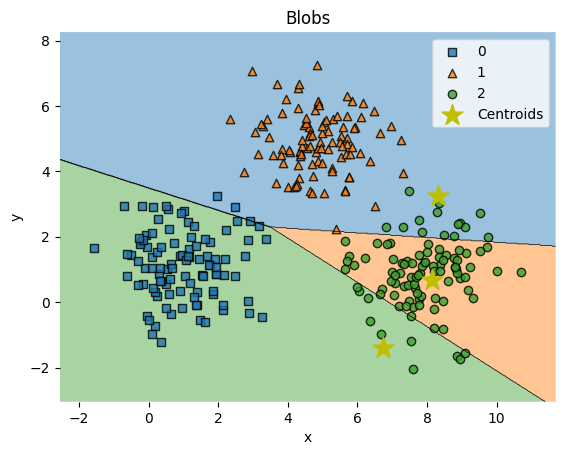

In [ ]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

clf = KMeans(3, None).fit(X,y)
df['Cluster label'] = clf.predict(df.iloc[:,:2]).astype(str)


plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250, label='Centroids')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Blobs')
plt.show()

## Visualize with Plotly

In [ ]:
fig = px.scatter(df, x='Feature 1', y='Feature 2', color='Cluster label',
                 color_continuous_scale=["red","green", "blue"],
                 title='Labeled Data', marginal_x="histogram", marginal_y="histogram")
fig.add_scatter(x= clf.centers[:,0], y=clf.centers[:,1],mode='markers',marker=dict(size=20, symbol="x", color='black'), name='Centroid')
fig.show()

## 2. K-Means++

This algorithm is made to solve the problem of initial centroids values.

K-means++
1. Choose one center uniformly at random from among the data points.
2. For each data point x, compute $D(x)$.
3. Choose the next centroid using a weighted probability distribution where a point x is chosen with probability proportional to  $𝐷(𝑥)^2$ .
4. Repeat until you have k points.

$D(x)$: the distance betweem x and the closest center

-----
### <span style="color:red">Task: Implement K-means++ algorithm for selecting the intial points.

In [ ]:
from itertools import pairwise
from numpy.random import choice


def choose(X, prob):
    # Return one point of X chosen randomly with probablity p
    # USE choise function in np.random (3 lines):
    n = X.shape[0]
    idx = choice(n, 1, p=prob)
    return X[idx]

def kmeans_pp(X, k):
    n = X.shape[0]
    weights = np.ones(n) / n
    centers = []
    while len(centers) < k:
        # Choose a centroid with the current weights
        centroid = choose(X, weights)
        centers.extend(centroid)
        # Calculate the pair-wise distances
        # between the datapoints X and the current centers
        # get min distance then square it.
        # Obtain new probabilities in weights.
        # TODO
        pairwise_dist = cdist(X, centers)
        dist = np.min(pairwise_dist, axis=1)
        d_squared = dist ** 2
        weights = dist / np.sum(dist)

    return np.array(centers)

initial_centers = kmeans_pp(X, 3)

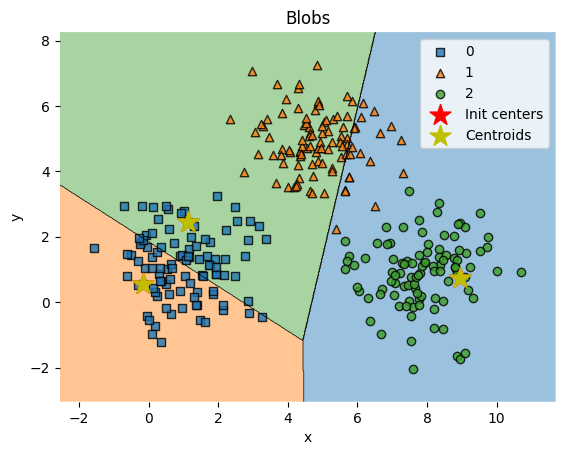

In [ ]:
clf = KMeans(3, initial_centers).fit(X,y)

plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.scatter(initial_centers[:,0], initial_centers[:,1], marker='*', c='r', s=250,label='Init centers')
plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250,label='Centroids')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Blobs')
plt.show()

## 3. How to choose k

### 3.1 Elbow method:

One way is to plot the sum of squared distances of samples to their centeriods vs number of clusters K.
Then, choose the K which the error doesn't decrease too much after.

In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])

fig = px.scatter(df, x='Feature 1', y='Feature 2', marginal_x="histogram", marginal_y="histogram",
                 color_continuous_scale=["red","green", "blue"],
                 title='My unlabeled data')
fig.show()

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

fig = px.line(y=wcss, x=range(1, 11), title='Elbow Method',  markers=True)
fig.update_layout(title="Elbow Method", xaxis_title="Number of clusters", yaxis_title="WCSS")
fig.show()

Another way is to measure the silhouette score for the clustering.
This score measures the separability between clusters and the cohesion inside the clusters.

Then, we take the K that has higher score.

## 2.2 Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score
silhouettes = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    y = kmeans.predict(X)
    score = silhouette_score(X, y)
    silhouettes.append(score)


fig = px.line(y=silhouettes, x=range(2, 11), markers=True)
fig.update_layout(title="Silhouette Method", xaxis_title="Number of clusters", yaxis_title="silhouette score")
fig.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

fig = px.scatter(df, x='Feature 1', y='Feature 2',
                 title='Labeled Data')
fig.add_scatter(x= kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1],mode='markers', marker=dict(size=20, symbol="x", color='red'),name='Centroid')
fig.show()

## Self practice task

  

Using [UNSW-NB15 Dataset](https://www.dropbox.com/s/nsvgwps3abdoxnq/clustering_data.zip?dl=1):

1. Preprocess the dataset
2. Reduce dimension using PCA
3. Remove outliers
4. Cluster the data using K-means (find the optimal number of k)
5. Visualize the data clusters (use PCA with 2 components)

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive


drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/innop_ml_seminar/lab12'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainset = pd.read_csv(path + '/trainset.csv')

In [ ]:
trainset.head()

dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   sttl  ...  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
0   252  ...           1                 1                 1               1   
1    62  ...           1                 1                 1               2   
2    62  ...           2                 1                 1               3   
3    62  ...           2                 1                 1               3   
4   254  ...           2                 2                 1              40   

   is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  \
0             0           0                 0           1           1   
1             0           0                 0           1           6   
2             0           0                 0           2           6   
3             1           1                 0           2           1   
4             0           0                 0           2          39   

   is_sm_ips_ports  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 42 columns]

In [ ]:
trainset.describe()

dur          spkts          dpkts        sbytes  \
count  175341.000000  175341.000000  175341.000000  1.753410e+05   
mean        1.359389      20.298664      18.969591  8.844844e+03   
std         6.480249     136.887597     110.258271  1.747656e+05   
min         0.000000       1.000000       0.000000  2.800000e+01   
25%         0.000008       2.000000       0.000000  1.140000e+02   
50%         0.001582       2.000000       2.000000  4.300000e+02   
75%         0.668069      12.000000      10.000000  1.418000e+03   
max        59.999989    9616.000000   10974.000000  1.296523e+07   

             dbytes          rate           sttl           dttl         sload  \
count  1.753410e+05  1.753410e+05  175341.000000  175341.000000  1.753410e+05   
mean   1.492892e+04  9.540619e+04     179.546997      79.609567  7.345403e+07   
std    1.436542e+05  1.654010e+05     102.940011     110.506863  1.883574e+08   
min    0.000000e+00  0.000000e+00       0.000000       0.000000  0.000000e+00   
25%    0.000000e+00  3.278614e+01      62.000000       0.000000  1.305334e+04   
50%    1.640000e+02  3.225807e+03     254.000000      29.000000  8.796748e+05   
75%    1.102000e+03  1.250000e+05     254.000000     252.000000  8.888889e+07   
max    1.465555e+07  1.000000e+06     255.000000     254.000000  5.988000e+09   

              dload  ...     ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  \
count  1.753410e+05  ...  175341.000000     175341.000000     175341.000000   
mean   6.712056e+05  ...       6.193936          5.383538          4.206255   
std    2.421312e+06  ...       8.052476          8.047104          5.783585   
min    0.000000e+00  ...       1.000000          1.000000          1.000000   
25%    0.000000e+00  ...       1.000000          1.000000          1.000000   
50%    1.447023e+03  ...       2.000000          1.000000          1.000000   
75%    2.784487e+04  ...       7.000000          5.000000          3.000000   
max    2.242273e+07  ...      51.000000         51.000000         46.000000   

       ct_dst_src_ltm   is_ftp_login     ct_ftp_cmd  ct_flw_http_mthd  \
count   175341.000000  175341.000000  175341.000000     175341.000000   
mean         8.729881       0.014948       0.014948          0.133066   
std         10.956186       0.126048       0.126048          0.701208   
min          1.000000       0.000000       0.000000          0.000000   
25%          1.000000       0.000000       0.000000          0.000000   
50%          3.000000       0.000000       0.000000          0.000000   
75%         12.000000       0.000000       0.000000          0.000000   
max         65.000000       4.000000       4.000000         30.000000   

          ct_src_ltm     ct_srv_dst  is_sm_ips_ports  
count  175341.000000  175341.000000    175341.000000  
mean        6.955789       9.100758         0.015752  
std         8.321493      10.756952         0.124516  
min         1.000000       1.000000         0.000000  
25%         2.000000       2.000000         0.000000  
50%         3.000000       4.000000         0.000000  
75%         9.000000      12.000000         0.000000  
max        60.000000      62.000000         1.000000  

[8 rows x 39 columns]

In [ ]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  object 
 2   service            175341 non-null  object 
 3   state              175341 non-null  object 
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl               175341 non-null  int64  
 11  sload              175341 non-null  float64
 12  dload              175341 non-null  float64
 13  sloss              175341 non-null  int64  
 14  dloss              175341 non-null  int64  
 15  sinpkt             175341 non-null  float64
 16  di

In [ ]:
trainset = trainset.sample(frac=0.1)

In [ ]:
pip install ydata_profiling

In [ ]:
from ydata_profiling import ProfileReport


# prof_report = ProfileReport(trainset)
# prof_report.to_file('prof_report.html')


No missing values but a lot of correlations between the data and a lot of duplicates - we can see it using profile report.
We will use isolation forest to deal with outliers

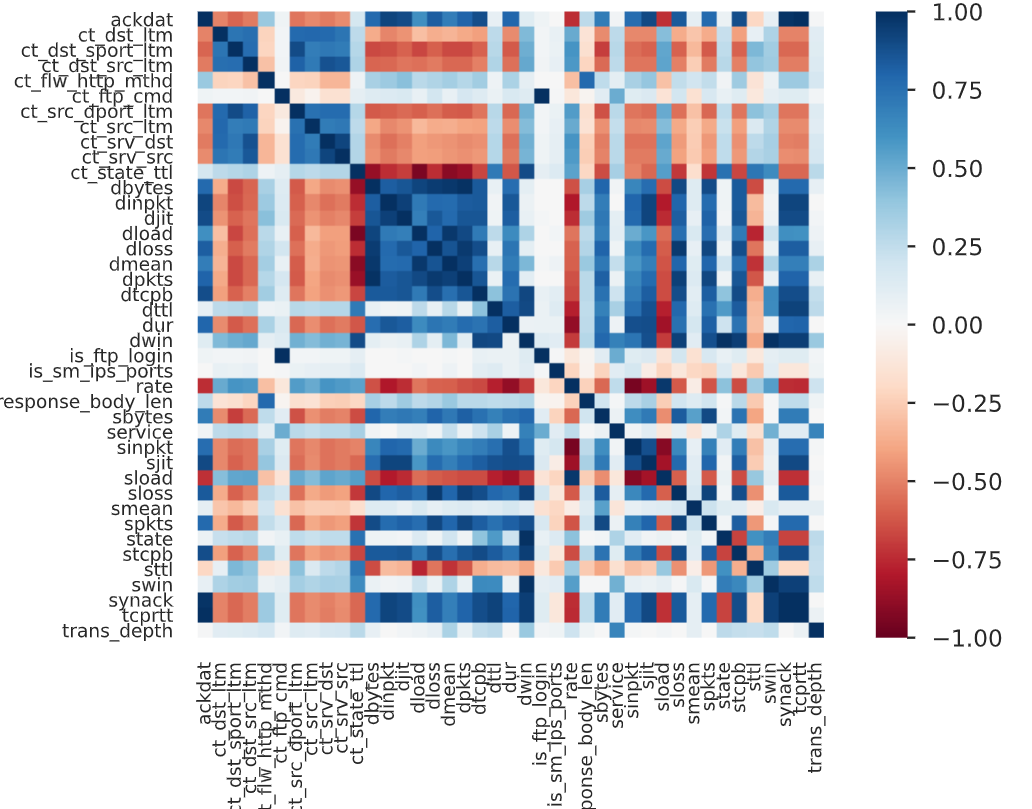

In [ ]:
trainset.drop_duplicates(inplace=True)

In [ ]:
cat_feat_names = trainset.select_dtypes(include=['object']).columns.to_list()
print(cat_feat_names)

['proto', 'service', 'state']


In [ ]:
# pip install category_encoders

we should leave values with a highest frequency only(proto) 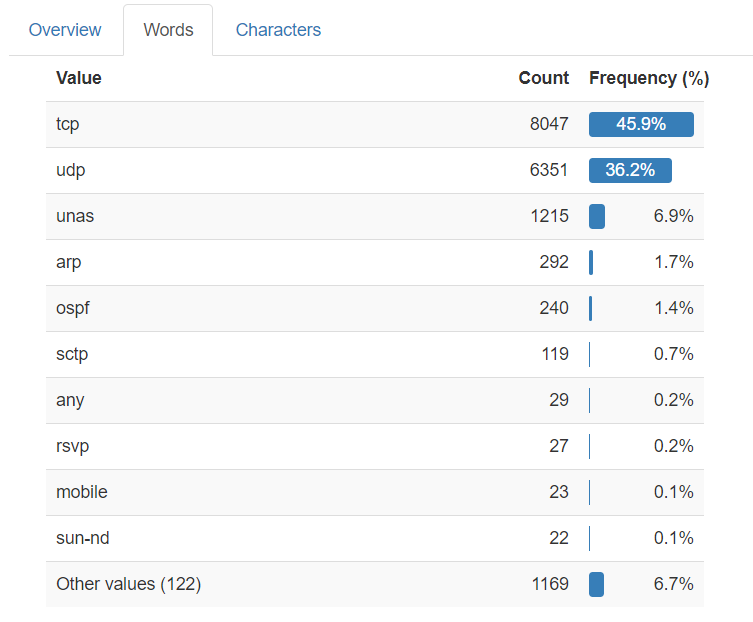

service

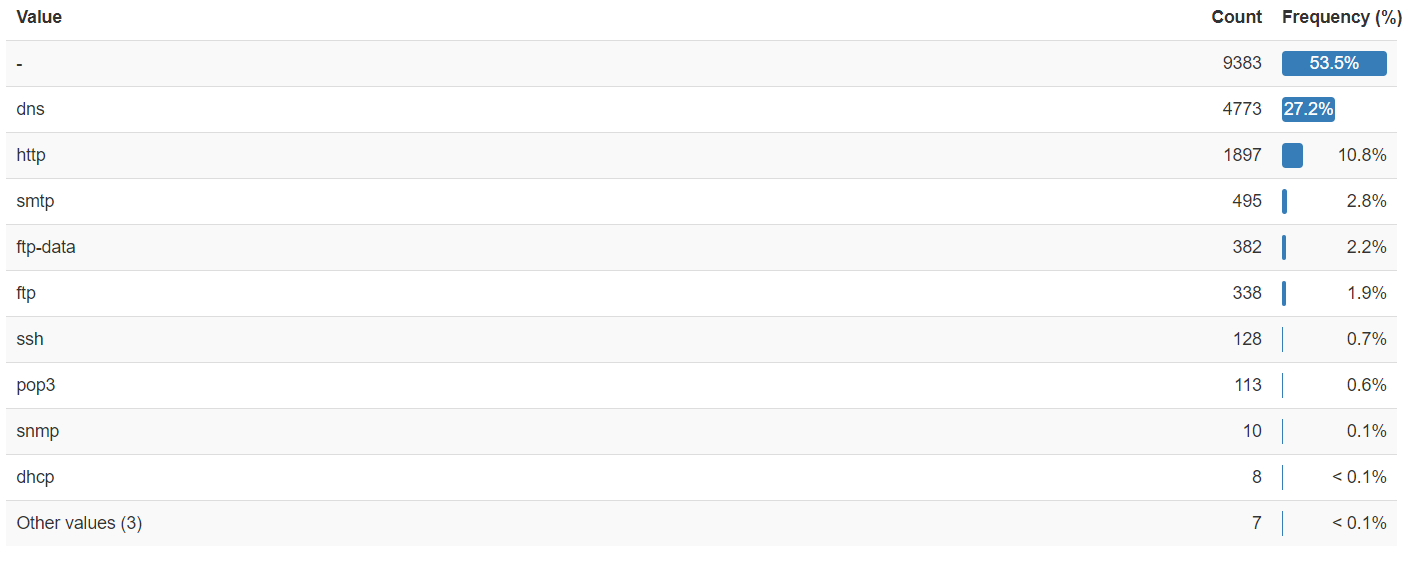

state

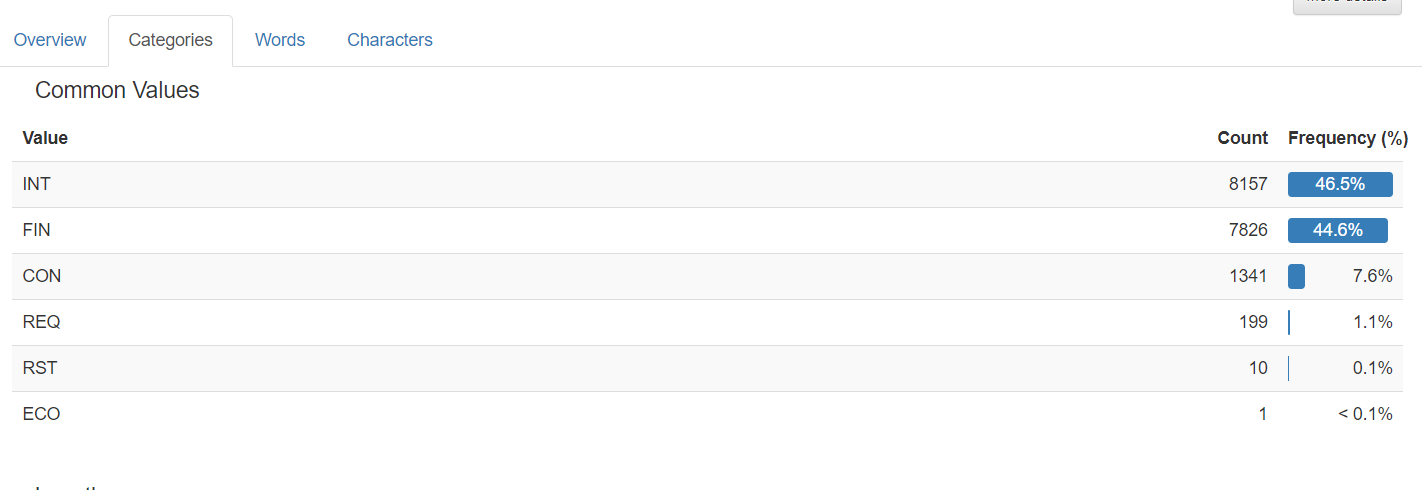

In [ ]:
for feat in cat_feat_names:
    counts = trainset[feat].value_counts(normalize=True)
    cumsum = np.cumsum(counts.values)
    len_cats = np.where(cumsum >= 0.95)[0][0] + 1
    print(f'Number of categories in {feat} are: {len_cats + 1}')
    trainset[feat] = np.where(trainset[feat].isin(counts.index[:len_cats]), trainset[feat], 'other')
    print(f'Unique values in {feat} are: {trainset[feat].unique()}\n')

Number of categories in proto are: 6
Unique values in proto are: ['udp' 'arp' 'other' 'unas' 'tcp' 'ospf']

Number of categories in service are: 6
Unique values in service are: ['-' 'dns' 'http' 'other' 'smtp' 'ftp-data']

Number of categories in state are: 4
Unique values in state are: ['INT' 'CON' 'FIN' 'other']



In [ ]:
from category_encoders import OneHotEncoder

encoder = OneHotEncoder(cols=cat_feat_names, use_cat_names=True)
trainset = encoder.fit_transform(trainset)
trainset.head()

dur  proto_udp  proto_arp  proto_other  proto_unas  proto_tcp  \
105600  0.000003          1          0            0           0          0   
111629  0.000000          0          1            0           0          0   
22130   0.004379          1          0            0           0          0   
151307  0.000003          0          0            1           0          0   
111192  0.000001          0          0            0           1          0   

        proto_ospf  service_-  service_dns  service_http  ...  ct_dst_ltm  \
105600           0          1            0             0  ...           1   
111629           0          1            0             0  ...           2   
22130            0          1            0             0  ...           5   
151307           0          1            0             0  ...           9   
111192           0          1            0             0  ...           2   

        ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
105600                 1                 1               2             0   
111629                 2                 2               2             0   
22130                  1                 1               3             0   
151307                 8                 8              10             0   
111192                 2                 2               3             0   

        ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  
105600           0                 0           1           3                0  
111629           0                 0           2           2                1  
22130            0                 0           3          14                0  
151307           0                 0           8          10                0  
111192           0                 0           2           3                0  

[5 rows x 55 columns]

In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
trainset_sc = scaler.fit_transform(trainset)
trainset_sc = pd.DataFrame(trainset_sc, columns=trainset.columns)
trainset_sc.head()

dur  proto_udp  proto_arp  proto_other  proto_unas  proto_tcp  \
0 -0.230958   1.515378  -0.115320    -0.228522   -0.171778  -1.215213   
1 -0.230958  -0.659901   8.671528    -0.228522   -0.171778  -1.215213   
2 -0.230255   1.515378  -0.115320    -0.228522   -0.171778  -1.215213   
3 -0.230958  -0.659901  -0.115320     4.375950   -0.171778  -1.215213   
4 -0.230958  -0.659901  -0.115320    -0.228522    5.821467  -1.215213   

   proto_ospf  service_-  service_dns  service_http  ...  ct_dst_ltm  \
0   -0.095168   0.910878     -0.49875     -0.409002  ...   -0.561177   
1   -0.095168   0.910878     -0.49875     -0.409002  ...   -0.413006   
2   -0.095168   0.910878     -0.49875     -0.409002  ...    0.031505   
3   -0.095168   0.910878     -0.49875     -0.409002  ...    0.624187   
4   -0.095168   0.910878     -0.49875     -0.409002  ...   -0.413006   

   ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0         -0.427134         -0.409279       -0.485209     -0.131822   
1         -0.275528         -0.187927       -0.485209     -0.131822   
2         -0.427134         -0.409279       -0.381008     -0.131822   
3          0.634108          1.140185        0.348406     -0.131822   
4         -0.275528         -0.187927       -0.381008     -0.131822   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  
0   -0.131822         -0.238998   -0.635869   -0.446329        -0.111914  
1   -0.131822         -0.238998   -0.495697   -0.552164         8.935405  
2   -0.131822         -0.238998   -0.355526    0.717853        -0.111914  
3   -0.131822         -0.238998    0.345334    0.294514        -0.111914  
4   -0.131822         -0.238998   -0.495697   -0.446329        -0.111914  

[5 rows x 55 columns]

In [ ]:
from sklearn.ensemble import IsolationForest


clf = IsolationForest(random_state=0, contamination=0.01)
clf.fit(trainset_sc)
y_pred = clf.predict(trainset_sc)
train_set_scaled = trainset_sc[y_pred == 1]
train_set_scaled.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(13125, 55)

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=0.9)
train_set_pca = pca.fit_transform(trainset_sc)
train_set_pca.shape

(13258, 21)

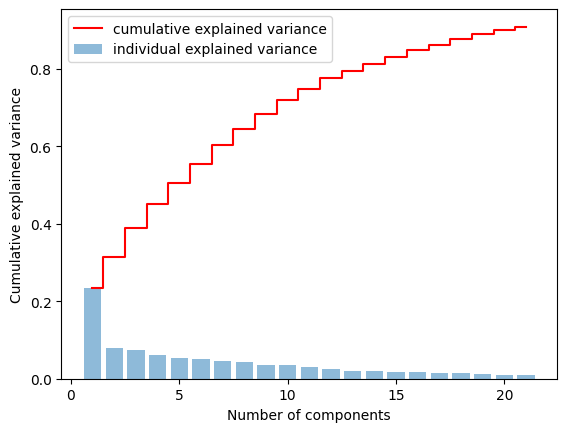

In [ ]:
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color='red')
plt.legend(loc='best')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
from sklearn.cluster import KMeans


wcss = []

for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_set_pca)
    wcss.append(kmeans.inertia_)

In [ ]:
def get_ratio(wcss, i):
    return (wcss[i] - wcss[i + 1]) / (wcss[i - 1] - wcss[i])

optimal_k = None
best_ratio = np.inf
for i in range(1, len(wcss) - 1):
    ratio = get_ratio(wcss, i)
    if ratio < best_ratio:
        best_ratio = ratio
        optimal_k = i + 1

print()
print(f'Optimal k is: {optimal_k}')


Optimal k is: 2


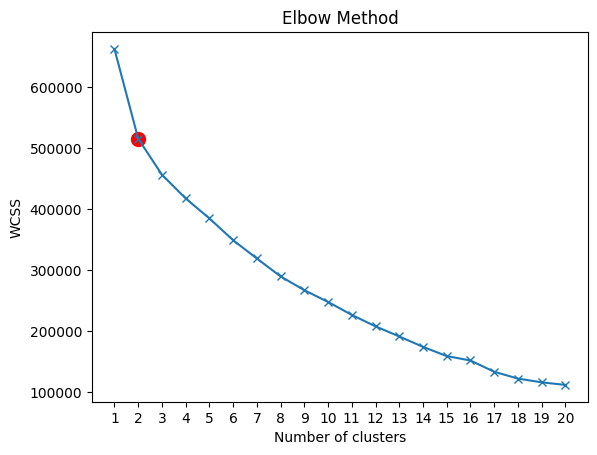

In [ ]:
plt.plot(range(1, 21), wcss, marker='x')
plt.scatter(optimal_k, wcss[optimal_k - 1], c='red', s=100)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.xticks(range(1, 21))
plt.ylabel('WCSS')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

silhouettes = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_set_pca)
    y = kmeans.predict(train_set_pca)
    score = silhouette_score(train_set_pca, y)
    silhouettes.append(score)

silhouettes

[0.311921637816522,
 0.32826212503863783,
 0.3323265883195099,
 0.29719306635780507,
 0.3014928047569027,
 0.3265556652242774,
 0.3518139447688497,
 0.35753027137859744,
 0.3715665704280385,
 0.40030783239861484,
 0.42052714227712246,
 0.43227281383290744,
 0.4598371849660537,
 0.4641000795611692,
 0.4907547134379135,
 0.5005146779446833,
 0.5073868602208872,
 0.49083363719771317,
 0.5025117687248611]

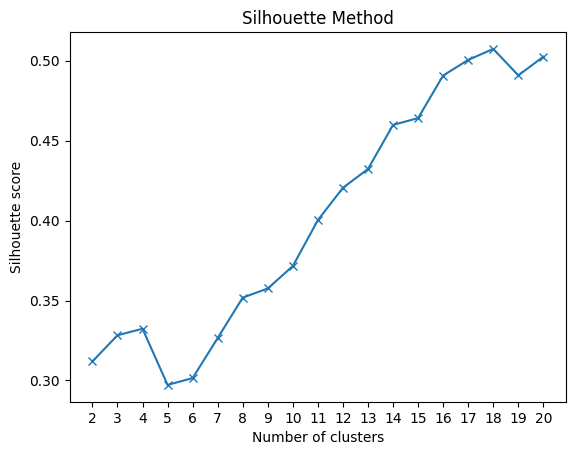

In [ ]:
plt.plot(range(2, 21), silhouettes, marker='x')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.xticks(range(2, 21))
plt.ylabel('Silhouette score')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_2 = kmeans.fit_predict(train_set_pca)

kmeans = KMeans(n_clusters=16, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_16 = kmeans.fit_predict(train_set_pca)


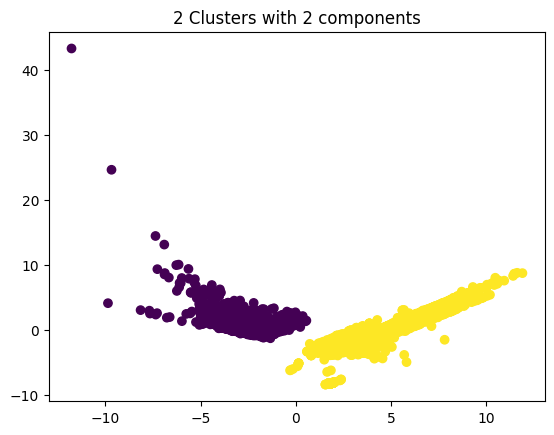

In [ ]:
train_set_pca_2 = PCA(n_components=2).fit_transform(train_set_pca)

plt.scatter(train_set_pca_2[:, 0], train_set_pca_2[:, 1], c=y_2, cmap='viridis')
plt.title('2 Clusters with 2 components')
plt.show()